<a href="https://colab.research.google.com/github/claudiofequfu/sedimentacao/blob/main/C%C3%B3pia_de_claudio2025Agosto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Iniciando a correção dos dados iniciais...
Região de melhor linearidade encontrada: pontos 50 a 137 com R² = 0.9999
Equação da reta: Altura = -0.0260 * Tempo + 32.8356
100 pontos iniciais foram corrigidos com base na tendência linear.


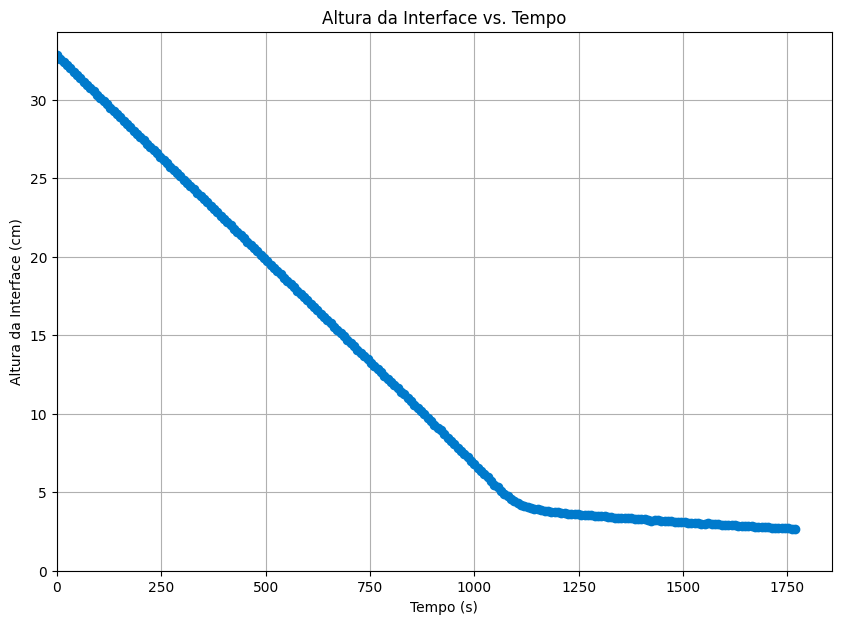

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os
from IPython.display import display, clear_output

def get_horizontal_crop_bounds(image):
    """
    Calcula os limites horizontais de corte com base na região não preta da imagem.
    A função identifica a primeira e a última coluna onde há pelo menos um pixel diferente de preto,
    e define o corte central (20% da largura da região clara), ou seja, de 40% a 60% da largura.
    """
    non_black_mask = np.any(image != 0, axis=2)
    columns_with_data = np.where(non_black_mask.any(axis=0))[0]

    if len(columns_with_data) == 0:
        return 0, image.shape[1]

    left_bound = columns_with_data[0]
    right_bound = columns_with_data[-1]
    nonblack_width = right_bound - left_bound
    crop_left = int(left_bound + 0.40 * nonblack_width)
    crop_right = int(left_bound + 0.60 * nonblack_width)
    return crop_left, crop_right

def calcular_altura_interface(image, corte_topo, corte_base, crop_left, crop_right):
    """
    Corta a imagem, converte para escala de cinza e calcula a altura da interface.
    """
    height, width = image.shape[:2]
    altura_total_cm = 34
    altura_corte_superior = int(height * corte_topo / 100)
    altura_corte_inferior = height - int(height * corte_base / 100)
    image_cropped = image[altura_corte_superior:altura_corte_inferior, crop_left:crop_right]

    gray_cropped = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2GRAY)
    pixels_interface = np.sum((gray_cropped >= 92) & (gray_cropped <= 240))
    pixels_total = image_cropped.shape[0] * image_cropped.shape[1]
    altura_interface_cm = altura_total_cm * pixels_interface / pixels_total

    return altura_interface_cm, gray_cropped, image_cropped

def extrair_frames(video_path, output_folder, corte_topo, corte_base, intervalo_extracao_segundos):
    """
    Extrai frames do vídeo, calcula e normaliza as alturas da interface ao longo do tempo.
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ret, first_frame = cap.read()
    if not ret:
        print("Não foi possível ler o vídeo.")
        return [], []
    crop_left, crop_right = get_horizontal_crop_bounds(first_frame)

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    intervalo_frames_extracao = int(fps * intervalo_extracao_segundos)

    alturas = []
    tempos = []

    for i in range(0, total_frames, intervalo_frames_extracao):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            altura_interface, _, _ = calcular_altura_interface(frame, corte_topo, corte_base, crop_left, crop_right)
            alturas.append(altura_interface)
            tempos.append(i / fps)
    cap.release()

    alturas = alturas[15:]
    tempos = tempos[15:]

    if alturas:
        altura_base = alturas[0]
        alturas = [34 * (h / altura_base) for h in alturas]
        tempos_np = np.array(tempos)
        tempos = (tempos_np - tempos_np[0]).tolist()

    return alturas, tempos

def identificar_e_ajustar_linearidade(tempos, alturas, min_pontos_para_reta=20, r2_threshold=0.99):
    """
    Identifica a região de linearidade inicial, ajusta uma reta a essa região
    e substitui os pontos originais da região linear pelos pontos previstos pela reta.
    """
    print("Iniciando a identificação da região de linearidade...")
    tempos_np = np.array(tempos)
    alturas_np = np.array(alturas)

    if len(tempos_np) < min_pontos_para_reta:
        print("Não há pontos suficientes para realizar o ajuste.")
        return tempos, alturas

    ultimo_ponto_linear = min_pontos_para_reta

    # Itera adicionando um ponto de cada vez para verificar quando o R² cai
    for i in range(min_pontos_para_reta + 1, len(tempos_np)):
        x_subset = tempos_np[:i]
        y_subset = alturas_np[:i]

        # Evita erro se todos os y forem iguais (raro, mas possível)
        if np.all(y_subset == y_subset[0]):
            continue

        coeffs = np.polyfit(x_subset, y_subset, 1)
        y_pred = np.polyval(coeffs, x_subset)

        ss_res = np.sum((y_subset - y_pred) ** 2)
        ss_tot = np.sum((y_subset - np.mean(y_subset)) ** 2)

        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

        # Se o R² cair abaixo do limiar, encontramos o fim da linearidade
        if r2 < r2_threshold:
            ultimo_ponto_linear = i - 1
            print(f"Quebra de linearidade detectada no ponto {i}. R² caiu para {r2:.4f}.")
            break
        # Se o loop terminar sem quebra, toda a série é considerada linear
        ultimo_ponto_linear = i

    print(f"Região de linearidade identificada até o ponto {ultimo_ponto_linear} (tempo ~{tempos_np[ultimo_ponto_linear]:.2f}s).")

    # Agora, faz o ajuste final usando SOMENTE a região linear identificada
    x_regiao_linear = tempos_np[:ultimo_ponto_linear]
    y_regiao_linear = alturas_np[:ultimo_ponto_linear]

    coef_angular, coef_linear = np.polyfit(x_regiao_linear, y_regiao_linear, 1)
    print(f"Equação da reta ajustada: Altura = {coef_angular:.4f} * Tempo + {coef_linear:.4f}")

    # Gera os novos pontos para a região linear com base na equação
    alturas_ajustadas_linear = coef_angular * x_regiao_linear + coef_linear

    # Concatena os pontos ajustados da região linear com os pontos originais da região não linear
    alturas_nao_lineares = alturas_np[ultimo_ponto_linear:]
    alturas_finais_corrigidas = np.concatenate((alturas_ajustadas_linear, alturas_nao_lineares))

    print(f"{ultimo_ponto_linear} pontos iniciais foram substituídos com base na tendência linear.")

    return tempos, alturas_finais_corrigidas.tolist()


# --- FLUXO PRINCIPAL DO SCRIPT ---

# Monta o Google Drive
drive.mount('/content/drive')
video_name = "TURMAB150725.mp4"
video_path = "/content/drive/My Drive/LEQ2/" + video_name
output_folder = "/content/frames"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define os cortes verticais e o intervalo de extração
corte_topo = 2
corte_base = 2
intervalo_extracao_segundos = 8

# Extrai os dados brutos de altura vs. tempo
alturas_originais, tempos = extrair_frames(video_path, output_folder, corte_topo, corte_base, intervalo_extracao_segundos)

# ** APLICAÇÃO DA NOVA LÓGICA DE CORREÇÃO **
tempos_corrigidos, alturas_corrigidas = identificar_e_ajustar_linearidade(tempos, alturas_originais)

# ** GRÁFICO FINAL COM EIXOS AJUSTADOS **
plt.figure(figsize=(12, 8))

# Plota os dados originais (com transparência) para comparação
plt.plot(tempos, alturas_originais, marker='.', linestyle='--', color='red', alpha=0.4, label='Dados Originais')

# Plota os dados corrigidos
plt.plot(tempos_corrigidos, alturas_corrigidas, marker='o', linestyle='-', color='#007ACC', markersize=5, label='Dados Corrigidos')

plt.title('Altura da Interface vs. Tempo (Ajuste Linear Aplicado)', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Altura da Interface (cm)', fontsize=12)
plt.legend()

# Ajusta os eixos para começarem em 0
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Cria um DataFrame com os dados corrigidos
dados_corrigidos = pd.DataFrame({'Tempo (s)': tempos_corrigidos, 'Altura da Interface (cm)': alturas_corrigidas})

# Salva o DataFrame em um arquivo Excel
excel_filename = 'dados_altura_vs_tempo_CORRIGIDO_NOVA_LOGICA.xlsx'
dados_corrigidos.to_excel(excel_filename, index=False, engine='openpyxl')

# Garante a instalação do openpyxl
!pip install openpyxl --quiet

# Força o download do arquivo
from google.colab import files
files.download(excel_filename)